This notebook replicates the cortex node from the Basal Ganglia network resting state simulation in Maith et al. 2020

Notes:
- how are unbalanced population sizes handled? does it not matter if one population is much bigger than the other? or is this information held in the weight?

In [1]:
import os
from collections import OrderedDict
import time
import numpy as np

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb_multiscale.core.config import Config, CONFIGURED

work_path = os.getcwd()
data_path = os.path.join(work_path.split("tvb_nest")[0], "data")
outputs_path = os.path.join(work_path, "outputs/IzhikevichExcIOInhI")
config = Config(output_base=outputs_path)

config.figures.SHOW_FLAG = True 
config.figures.SAVE_FLAG = True
config.figures.FIG_FORMAT = 'png'

from tvb_multiscale.core.plot.plotter import Plotter
plotter = Plotter(config)

try:
    from tvb_multiscale.core.tvb.io.h5_writer import H5Writer
    writer = H5Writer()
except:
    writer = None
    
# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline 

In [2]:
np.array([0.0337*4,])

array([0.1348])

## 1. Prepare TVB simulator <br> (including structural data -minimally a TVB connectivity, region mean field model, integrator, monitors etc)

In [3]:
from tvb_multiscale.core.tvb.cosimulator.cosimulator_builder import CoSimulatorBuilder
from tvb.datatypes.connectivity import Connectivity
from tvb_multiscale.core.tvb.cosimulator.models.izhikevich_exc_io_inh_i import IzhikevichExcIOInhI

# Using the tvb-multdiscale simulator builder with default choices...
simulator_builder = CoSimulatorBuilder()

simulator_builder.model = IzhikevichExcIOInhI()
simulator_builder.model_params = \
    {"I_ext":   np.array([7.0,]), 
     "G":   np.array([0.0,]),  # G / N_E to normalize for the order of the spiking networks
     "ce": np.array([-72.0,]),
     "ci": np.array([-72.0,]),
     "de": np.array([6.0,]),
     "di": np.array([6.0,]),
     "wee": np.array([0.0,]),
     "wii": np.array([0.4*0.4,]), # standard weight*prob
     "wie": np.array([0.0337*0.4*4,]), # factor 4 because E: 600 neurons, I: 150 neurons.
     "wei": np.array([0.3*0.4,])
    }

simulator_builder.connectivity = Connectivity(weights=np.array([[0.0, 1.0], [1.0, 0.0]]), 
                                              tract_lengths=np.array([[0.3, 3.0], [3.0, 0.3]]), 
                                              centres=np.array([[0.0, 0.0, 0.0], [1.0, 1.0, 1.0]]), 
                                              region_labels=np.array(["Region0", "Region1"]))
# simulator_builder.connectivity = Connectivity.from_file(config.DEFAULT_CONNECTIVITY_ZIP)

simulator_builder.dt = 0.1
#                                                   S_e, S_i, V_e, V_i, U_e, U_i, R_e, R_i, I_e, I_i
simulator_builder.noise_strength = 0.0*np.array([config.DEFAULT_NSIG, config.DEFAULT_NSIG, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

simulator_builder.initial_conditions = np.array([0.0, 0.0, -72.0, -72.0, -14.0, -14.0, 0.0, 0.0, 0.0, 0.0])
# Initial conditions shape [history_points, state_variables, brain_regions, modes)]
simulator_builder.initial_conditions = \
    simulator_builder.initial_conditions[None, :, None, None]

simulator = simulator_builder.build()

# linear coupling: a * x + b
# simulator.coupling.a = 1.0/256
# simulator.coupling.b = 0.0

simulator.simulation_length = 1000.0  # ms

# plotter.plot_tvb_connectivity(simulator.connectivity)


2021-06-23 17:36:06,433 - INFO - tvb_multiscale.core.tvb.cosimulator.cosimulator - Region simulation with 2 ROI nodes
2021-06-23 17:36:06,435 - INFO - tvb_multiscale.core.tvb.cosimulator.cosimulator - Memory requirement estimate: simulation will need about 0.0 MB
2021-06-23 17:36:06,437 - INFO - tvb_multiscale.core.tvb.cosimulator.cosimulator - Using provided initial history of shape (11, 10, 2, 1)
2021-06-23 17:36:06,440 - INFO - tvb_multiscale.core.tvb.cosimulator.cosimulator - Final initial history shape is (11, 10, 2, 1)
2021-06-23 17:36:06,445 - INFO - tvb_multiscale.core.tvb.cosimulator.cosimulator - Memory requirement census: simulation will need about 0.0 MB


In [4]:
results = simulator.run()  
# Gather the results: 
# list of monitors' outputs: [(time, data), (time, data), (time, data)]
time = results[0][0]
data = results[0][1] # shape: (n timepoints, n state variables, regions, models)

2021-06-23 17:36:06,454 - INFO - tvb_multiscale.core.tvb.cosimulator.cosimulator - Simulation runtime should be about 1.314 seconds
2021-06-23 17:36:06,456 - INFO - tvb_multiscale.core.tvb.cosimulator.cosimulator - Calculating storage requirement for ...
2021-06-23 17:36:06,460 - INFO - tvb_multiscale.core.tvb.cosimulator.cosimulator - Calculated storage requirement for simulation: 1800000 


/home/docker/packages/tvb-multiscale/tvb_multiscale/core/tvb/cosimulator/models/izhikevich_exc_io_inh_i.py:477: RuntimeWarning: overflow encountered in exp
  dV_e = self._nfun_e(V_e) - xi_e * numpy.exp(eta_e * (V_e - self.ce))
/home/docker/packages/tvb-multiscale/tvb_multiscale/core/tvb/cosimulator/models/izhikevich_exc_io_inh_i.py:425: RuntimeWarning: overflow encountered in multiply
  He = 1.0 / (1 + numpy.exp(-self.omega * (V_e - self.ce)))
/home/docker/packages/tvb-multiscale/tvb_multiscale/core/tvb/cosimulator/models/izhikevich_exc_io_inh_i.py:475: RuntimeWarning: divide by zero encountered in true_divide
  eta_e = self._dnck_e / ncknc_e
/home/docker/packages/tvb-multiscale/tvb_multiscale/core/tvb/cosimulator/models/izhikevich_exc_io_inh_i.py:476: RuntimeWarning: invalid value encountered in true_divide
  xi_e = ncknc_e / numpy.exp(eta_e * self.kappa)
/home/docker/packages/tvb-multiscale/tvb_multiscale/core/tvb/cosimulator/models/izhikevich_exc_io_inh_i.py:363: RuntimeWarning: ove

2021-06-23 17:36:18,769 - INFO - tvb_multiscale.core.tvb.cosimulator.cosimulator - 12.315 s elapsed, 12.315x real time


In [5]:
data[0:10, 0, 0, 0] == data[0:10, 0, 1, 0]
data.shape

(10000, 10, 2, 1)

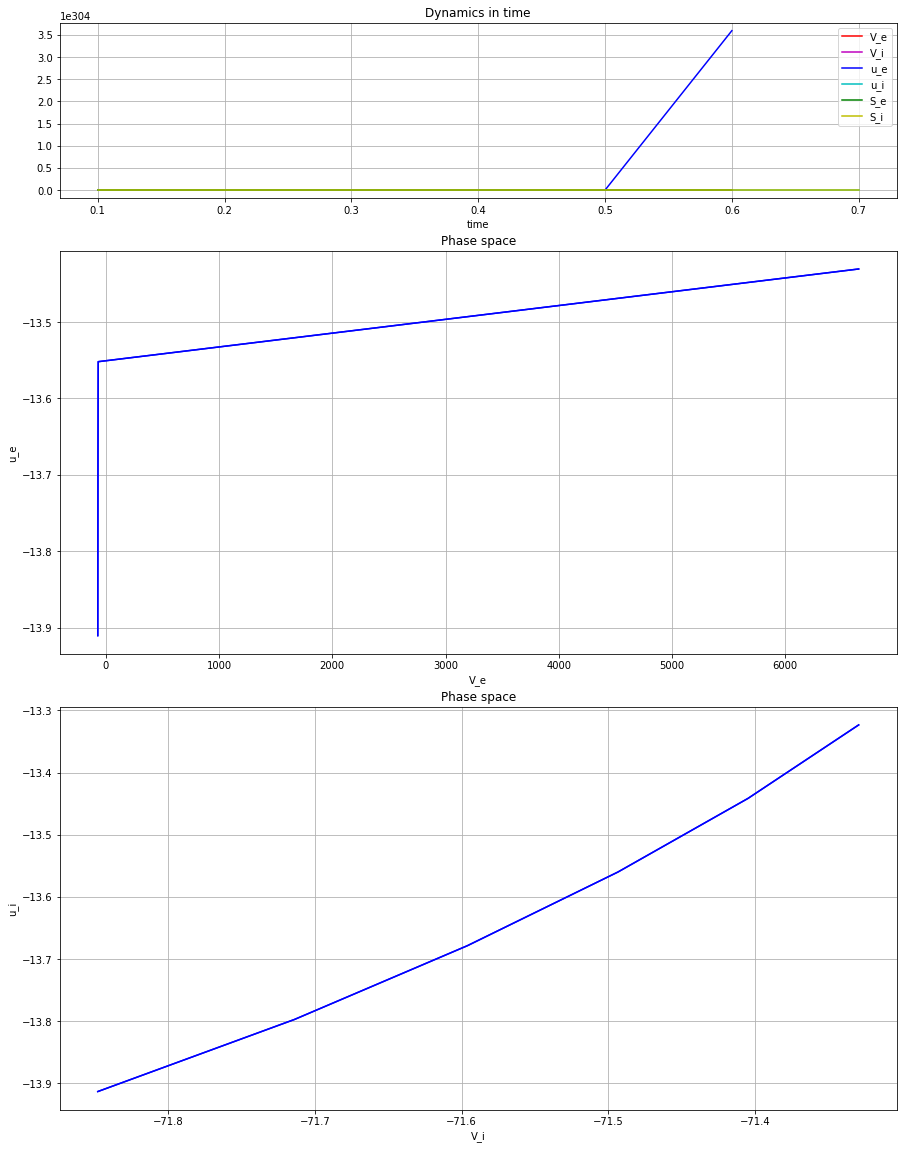

In [6]:
import matplotlib.pyplot as plt
#plot
fig = plt.figure(figsize=(15,20))
fig.subplots_adjust(wspace = 0.5, hspace = 0.3)
ax1 = fig.add_subplot(5,1,1)
ax2 = fig.add_subplot(5,1,(2, 3))
ax3 = fig.add_subplot(5,1,(4, 5))

ax1.plot(time, data[:, 2, 0, 0], 'r-', label='V_e')
ax1.plot(time, data[:, 3, 0, 0], 'm-', label='V_i')
ax1.plot(time, data[:, 4, 0, 0], 'b-', label='u_e')
ax1.plot(time, data[:, 5, 0, 0], 'c-', label='u_i')
ax1.plot(time, data[:, 0, 0, 0], 'g-', label='S_e')
ax1.plot(time, data[:, 1, 0, 0], 'y-', label='S_i')
#ax1.plot(z, 'g-', label='prey')
ax1.set_title("Dynamics in time")
ax1.set_xlabel("time")
ax1.grid()
ax1.legend(loc='best')

ax2.plot(data[:, 2, :, 0], data[:, 4, :, 0], color="blue")
ax2.set_xlabel("V_e")
ax2.set_ylabel("u_e")  
ax2.set_title("Phase space")
ax2.grid()

ax3.plot(data[:, 3, :, 0], data[:, 5, :, 0], color="blue")
ax3.set_xlabel("V_i")
ax3.set_ylabel("u_i")  
ax3.set_title("Phase space")
ax3.grid()

plt.show()

In [7]:
t = results[0][0]
source = results[0][1]

# Put the results in a Timeseries instance
from tvb.contrib.scripts.datatypes.time_series_xarray import TimeSeriesRegion

source_ts = TimeSeriesRegion(data, time=t,
               connectivity=simulator.connectivity,
               labels_ordering=["Time", "State Variable", "Region", "Neurons"],
               labels_dimensions=
                    {"State Variable": simulator.model.state_variables,
                     "Region": simulator.connectivity.region_labels.tolist()},
               sample_period=simulator.integrator.dt)
source_ts.configure()

writer.write_tvb_to_h5(source_ts, os.path.join(config.out.FOLDER_RES, source_ts.title.replace(" ", "_") + ".h5"))

source_ts 


,value
Dimensions,"['Time', 'State Variable', 'Region', 'Neurons']"
Length,10000
Region Mapping,None
Region Mapping Volume,None
Sample period,0.09999999999999999
Source Connectivity,Connectivity gid: 37e54855-dede-40ea-9b87-a7dc11d377df
Time units,ms
Time-series name,Region Time Series
Time-series type,TimeSeriesRegion
"[min, median, max]","[nan, nan, nan]"


In [8]:
# Separate mean field time series into different populations
from pandas import Series

from tvb_multiscale.core.utils.computations_utils import compute_tvb_spike_rate_corrs
mean_field = source_ts
tvb_rates = source_ts[:, 3]
tvb_rates.title = "Region mean field rate time series"
    
tvb_corrs = compute_tvb_spike_rate_corrs(tvb_rates)
if writer is not None:
    writer.write_tvb_to_h5(tvb_rates, os.path.join(config.out.FOLDER_RES, tvb_rates.title.replace(" ", "_")) + ".h5",
                           recursive=False)
writer.write_object(tvb_corrs, path=os.path.join(config.out.FOLDER_RES, "TVB_corrs") + ".h5")


2021-06-23 17:36:19,727 - INFO - tvb_multiscale.core.tvb.io.h5_writer - Starting to write dict to: /home/docker/packages/tvb-multiscale/examples/notebooks/outputs/IzhikevichExcIOInhI/res/TVB_corrs.h5
2021-06-23 17:36:19,727 - INFO - tvb_multiscale.core.tvb.io.h5_writer - Starting to write dict to: /home/docker/packages/tvb-multiscale/examples/notebooks/outputs/IzhikevichExcIOInhI/res/TVB_corrs.h5
2021-06-23 17:36:19,747 - WARNING - tvb_multiscale.core.tvb.io.h5_writer - 
Writing <class 'tuple'> dims to h5 file as a numpy array dataset !

2021-06-23 17:36:19,747 - WARNING - tvb_multiscale.core.tvb.io.h5_writer - 
Writing <class 'tuple'> dims to h5 file as a numpy array dataset !

2021-06-23 17:36:19,753 - WARNING - tvb_multiscale.core.tvb.io.h5_writer - 
Writing <class 'list'> data to h5 file as a numpy array dataset !

2021-06-23 17:36:19,753 - WARNING - tvb_multiscale.core.tvb.io.h5_writer - 
Writing <class 'list'> data to h5 file as a numpy array dataset !

2021-06-23 17:36:19,760 - 

(<Closed HDF5 file>,
 '/home/docker/packages/tvb-multiscale/examples/notebooks/outputs/IzhikevichExcIOInhI/res/TVB_corrs.h5')

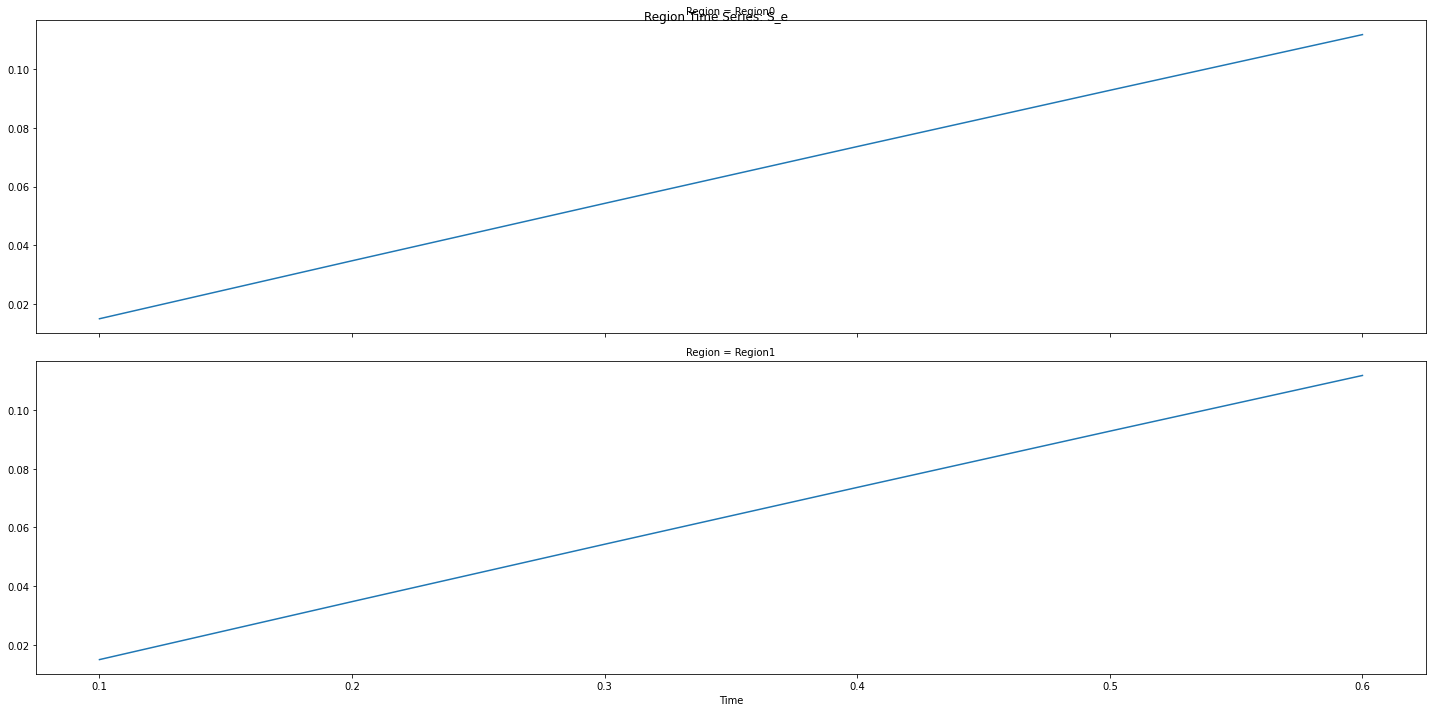

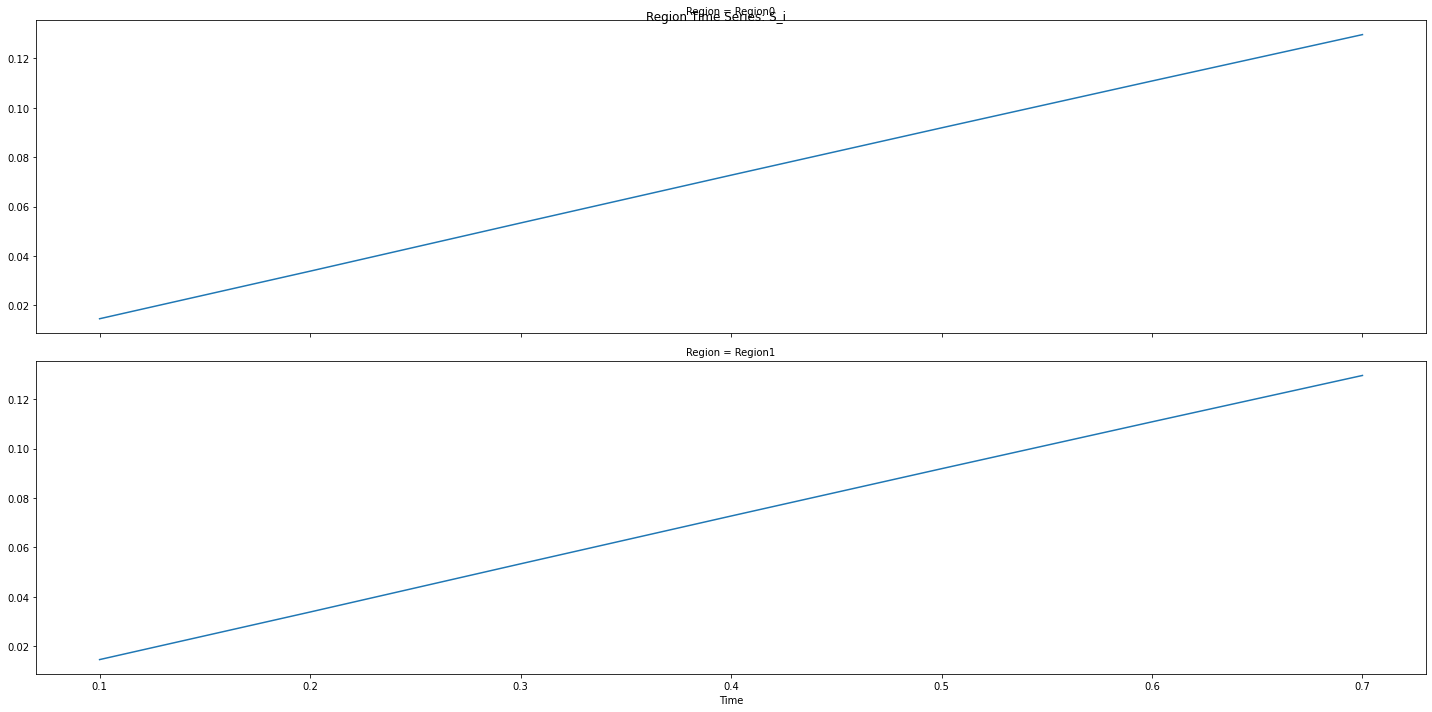

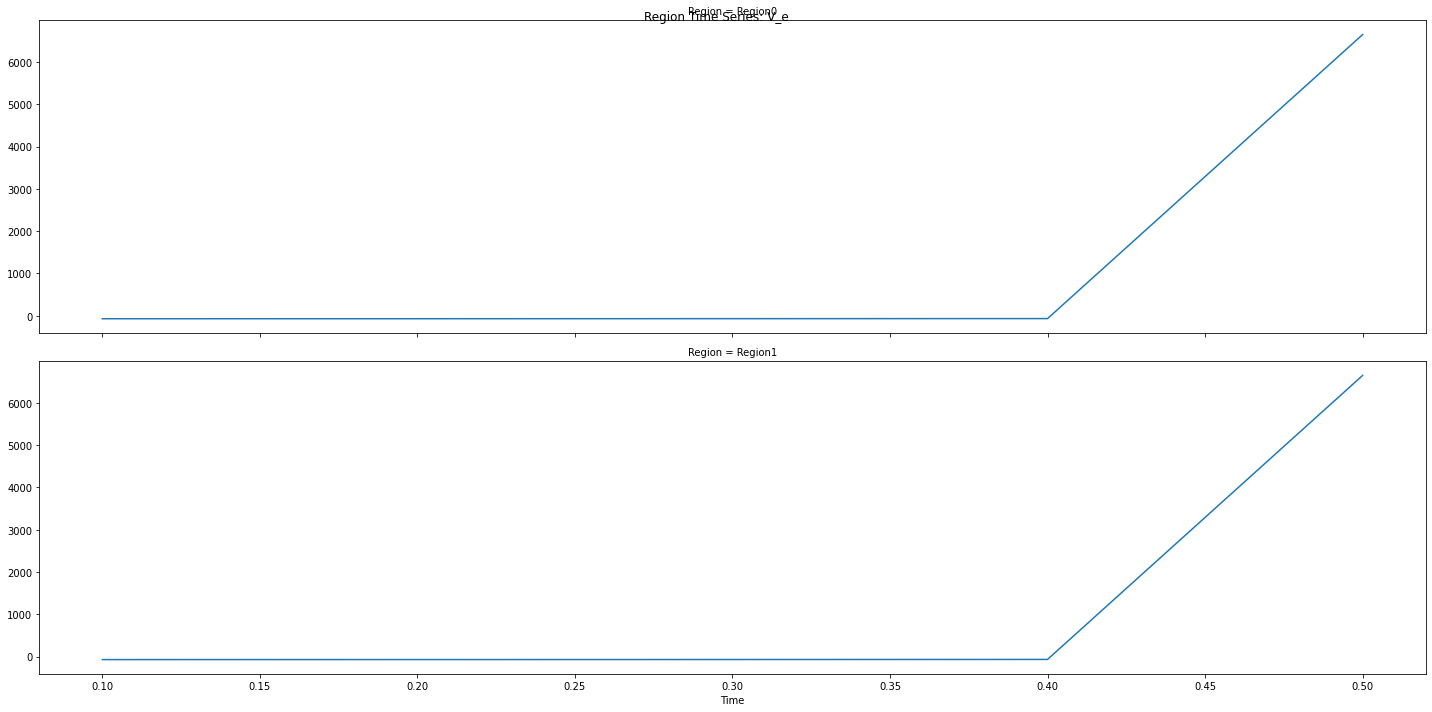

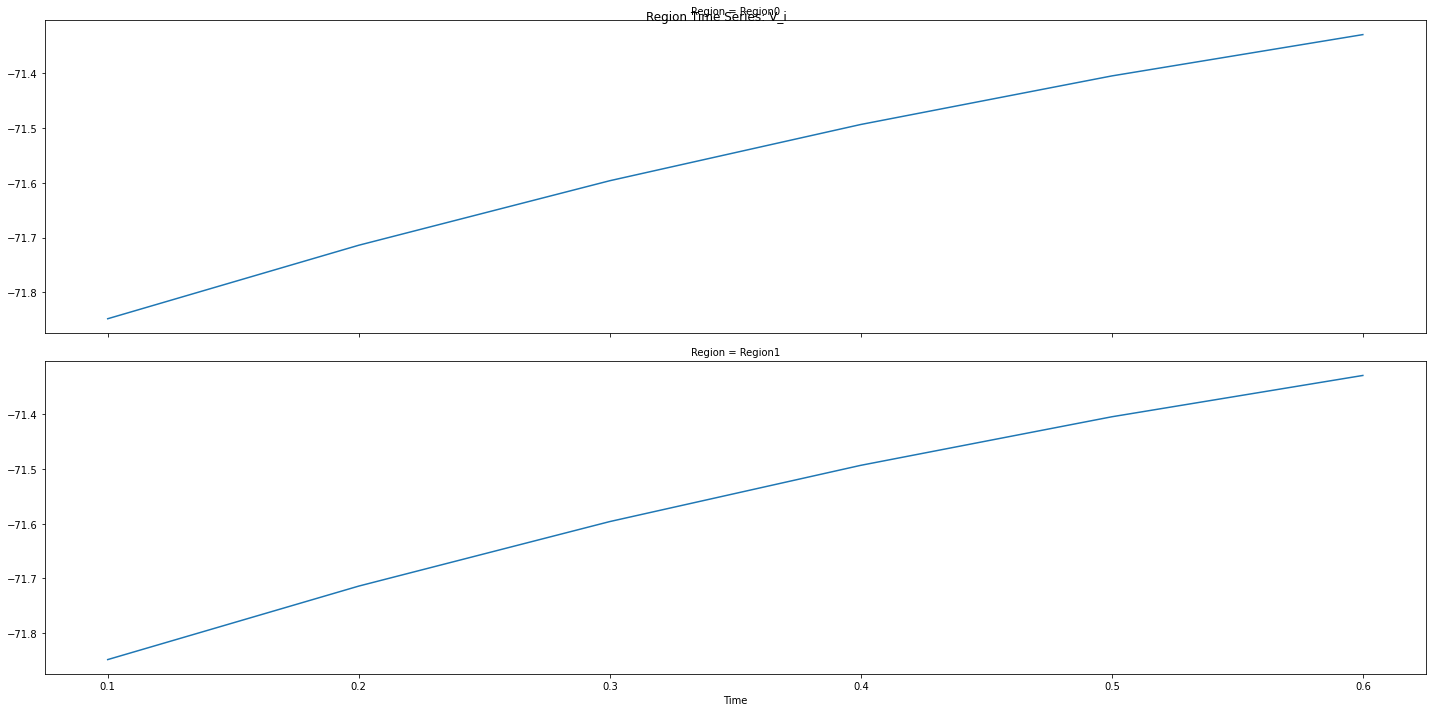

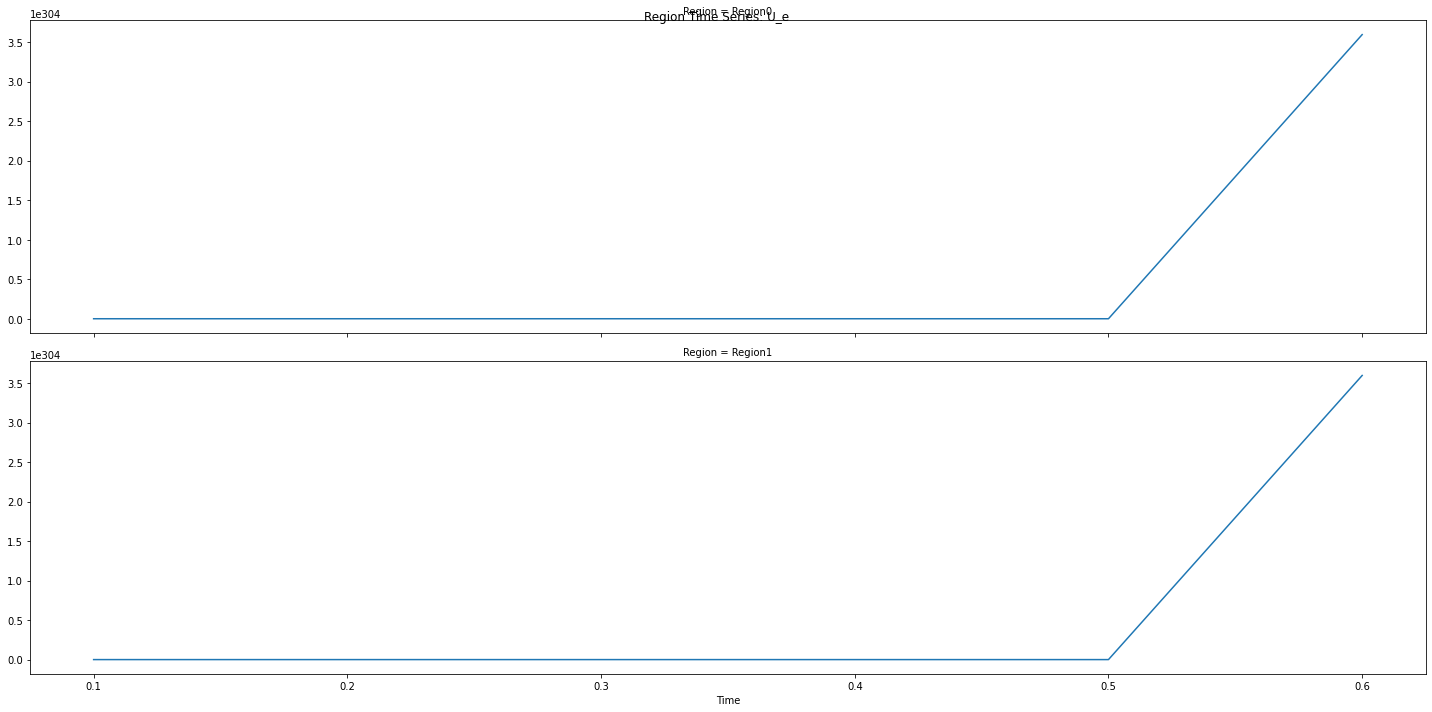

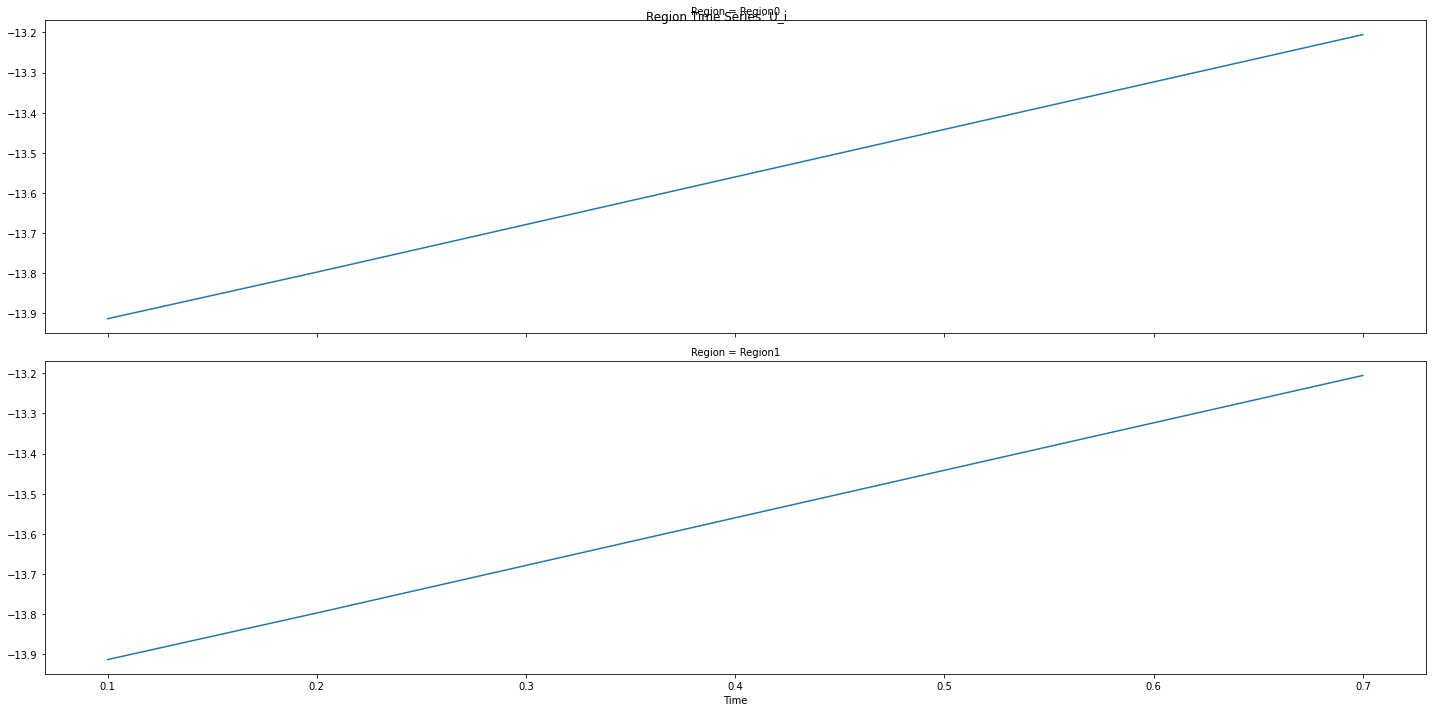

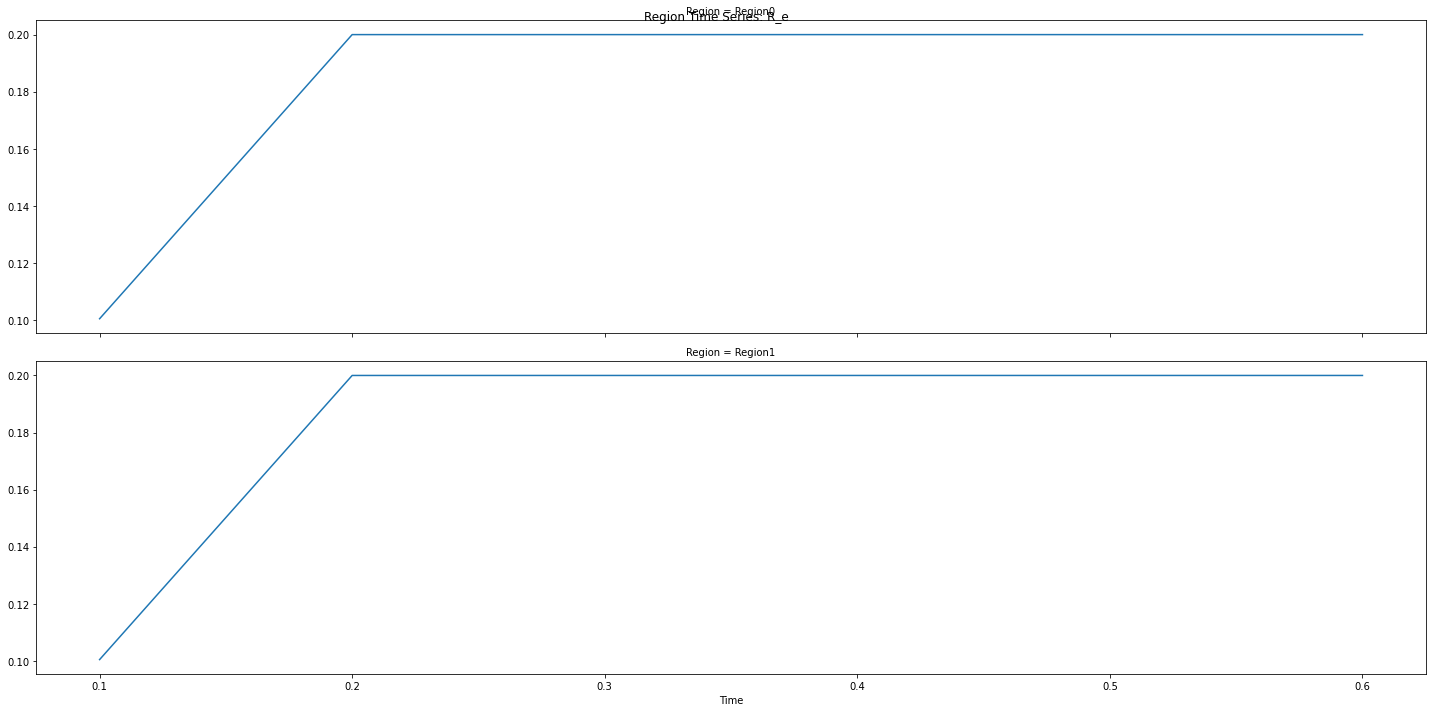

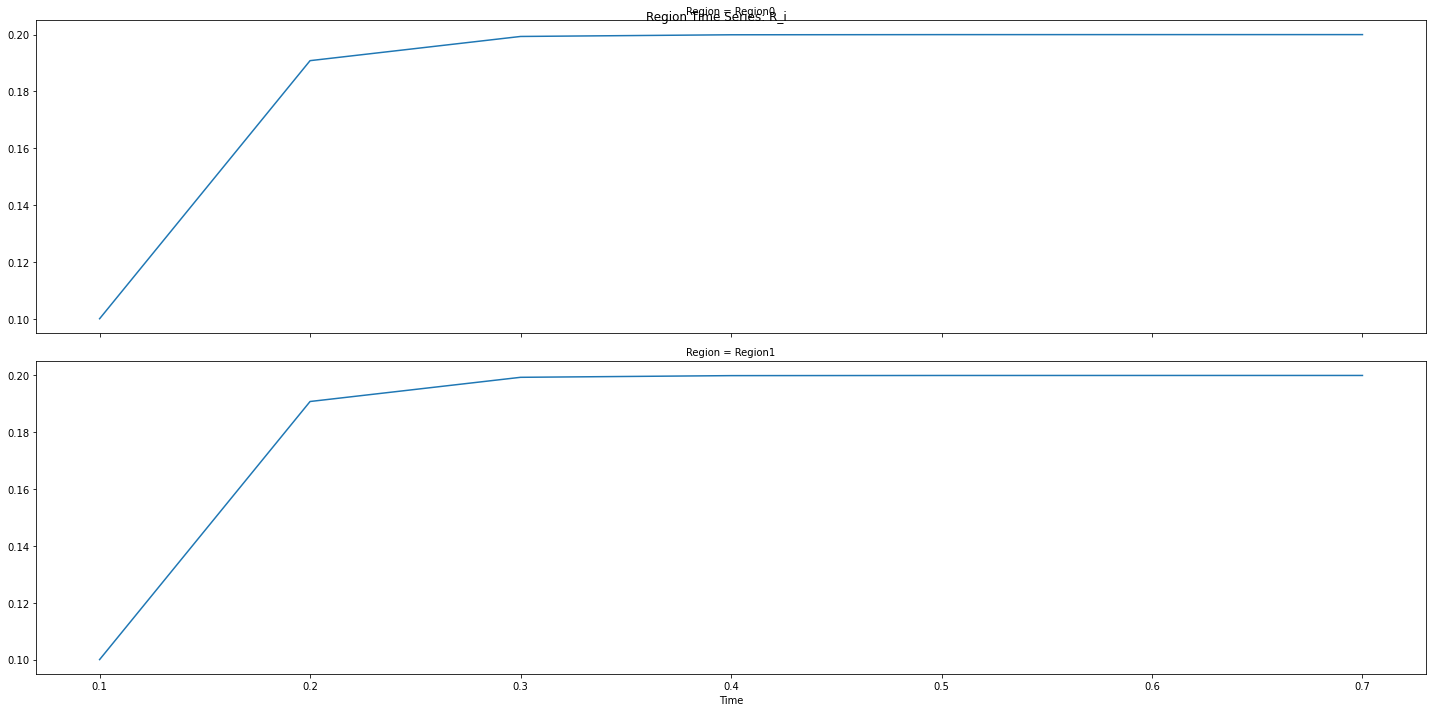

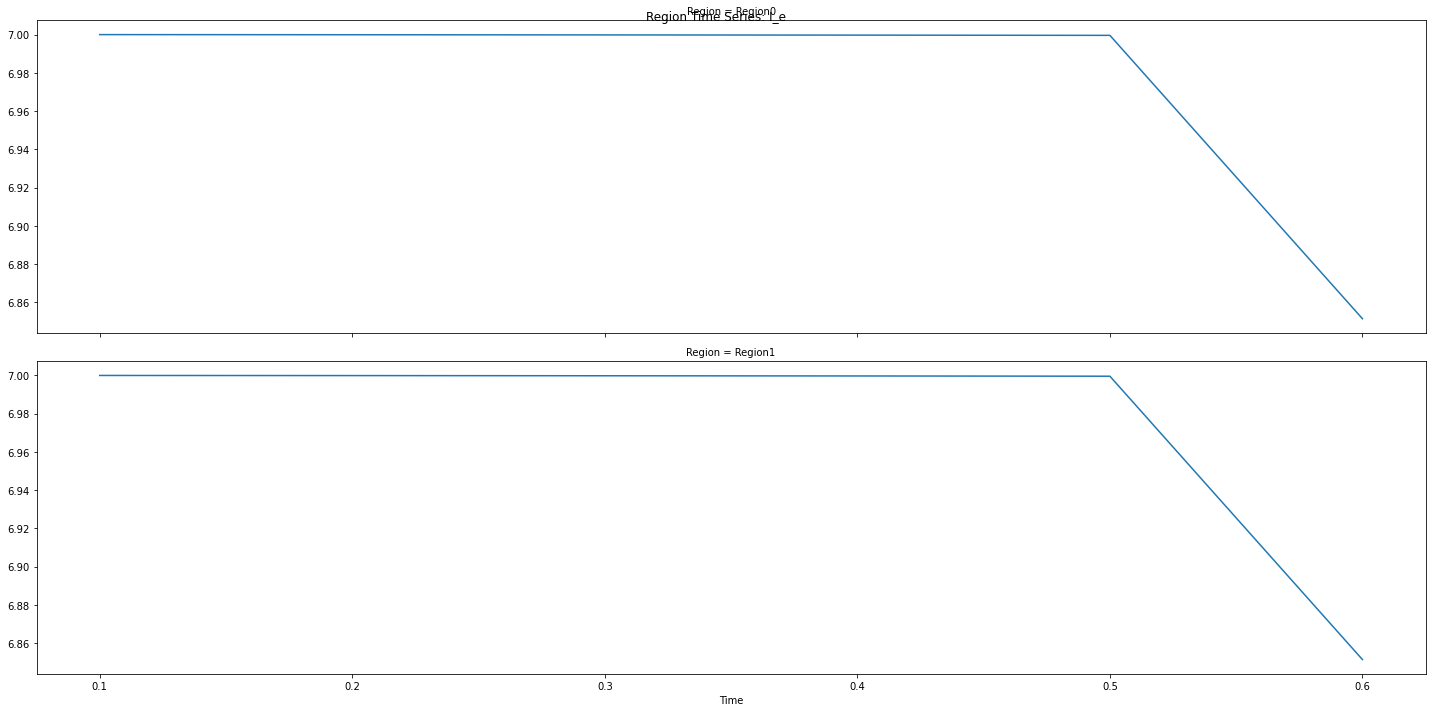

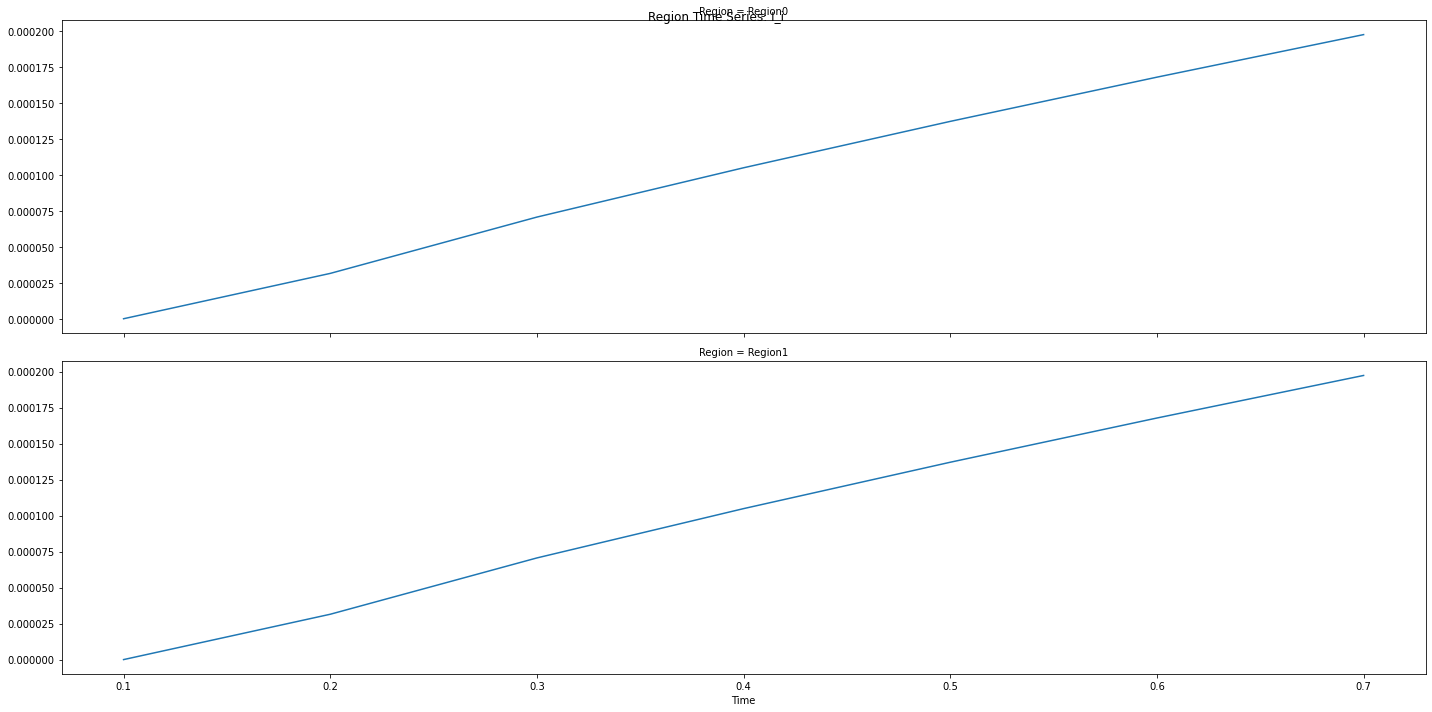

In [9]:
# For raster plot:
mean_field.plot_timeseries(plotter_config=plotter.config, per_variable=True, 
                           figsize=config.figures.NOTEBOOK_SIZE, add_legend=False)
if mean_field.number_of_labels > 9:
    mean_field.plot_raster(plotter_config=plotter.config, per_variable=True, 
                           figsize=config.figures.NOTEBOOK_SIZE, add_legend=False)

### Interactive time series plot

In [10]:
# # ...interactively as well
# # For interactive plotting:
# %matplotlib notebook 
# plotter.plot_timeseries_interactive(source_ts)

In [11]:
config.DEFAULT_NSIG

0.001